In [1]:
import pandas as pd
import numpy as np

In [2]:
from myLibs.meteorologicalAnalysis import estimate_precipitation_percent

In [3]:
# -----------------------------------------------------------------------------
# Step 0: Define file paths and severe-weather time window
# -----------------------------------------------------------------------------
input_path = "Data/Raw/RawDataset_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"
output_path = "Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"

SEVERE_START = pd.Timestamp("2025-01-15 12:20")
SEVERE_END   = pd.Timestamp("2025-01-18 22:59")

# -----------------------------------------------------------------------------
# Step 1: Load raw weather data
# -----------------------------------------------------------------------------
df = pd.read_csv(input_path, parse_dates=['Timestamp'])

# -----------------------------------------------------------------------------
# Step 2: Estimate precipitation percentage
# -----------------------------------------------------------------------------
df['Precipitation_%'] = df.apply(
    lambda row: estimate_precipitation_percent(
        temp_c=row['Temperature_C'],
        wind_kmh=row['Wind_km_h'],
        humidity_pct=row['Humidity_%']
    ),
    axis=1
)

# # -----------------------------------------------------------------------------
# # Step 3: (Optional) Handle severe-weather period
# # -----------------------------------------------------------------------------
# # Example: ensure severe-weather period values aren’t scaled down or clipped.
# mask = (df['Timestamp'] >= SEVERE_START) & (df['Timestamp'] <= SEVERE_END)
# df.loc[mask, 'Precipitation_%'] = df.loc[mask, 'Precipitation_%'].clip(lower=80)
# # ↑ This ensures that during the severe window, precipitation likelihood is at least 80%.

# # -----------------------------------------------------------------------------
# # Step 4: Save processed dataset
# # -----------------------------------------------------------------------------
# df.to_csv(output_path, index=False)

# print(f"Processed dataset saved to: {output_path}")


# -----------------------------------------------------------------------------
# Step 3: Smooth the precipitation percentage with a centered moving average
# -----------------------------------------------------------------------------
# We use a 7-point window (≈3 hours on either side if data is hourly).
# center=True ensures the average is centered at each data point.
# min_periods=1 means that near edges (where fewer than 7 points exist), it will average
# whatever points are available.
df['Precipitation_%'] = (
    df['Precipitation_%']
    .rolling(window=3, center=True, min_periods=1)
    .mean()
    .round(2)
)


# -----------------------------------------------------------------------------
# Step 4: Scale down values outside the severe weather period
# -----------------------------------------------------------------------------
# Rationale:
#   - Outside the severe weather window, large spikes in precipitation_% may be
#     unrealistic. We will find the maximum observed precipitation_% outside the severe window.
#   - If that maximum exceeds 35%, we scale all outside values so that the new maximum is 14%.
#   - After scaling, any value below 7% is considered negligible and set to 0%.
#
# First, identify the maximum precipitation_% outside the severe-window.
mask_outside = (df['Timestamp'] < SEVERE_START) | (df['Timestamp'] > SEVERE_END)
max_outside_pct = df.loc[mask_outside, 'Precipitation_%'].max()

def scale_outside_severe(row):
    """
    For timestamps outside the severe window, scale the smoothed precipitation_%
    if the maximum outside % > 35. Then zero-out small values (< 7%).
    Inside the severe window, return the original smoothed percentage unchanged.
    """
    timestamp = row['Timestamp']
    pct_value = row['Precipitation_%']
    
    # Check if this row is outside the severe window:
    if (timestamp < SEVERE_START) or (timestamp > SEVERE_END):
        if max_outside_pct > 25.0:
            # Scale so that the previous max_outside_pct maps to 14% maximum
            # scaled = pct_value * (20.0 / max_outside_pct)
            scaled = pct_value * .001
        else:
            # If max_outside_pct ≤ 35%, do not scale; keep pct_value as-is
            scaled = pct_value
        
        # If the scaled value is below 7%, treat as no precipitation (0.0%)
        if scaled < 5.0:
            return 0.0
        else:
            return round(scaled, 2)
    
    # During the severe window, return the smoothed percentage unchanged
    return pct_value

# Apply the scaling function
# df['Precipitation_%'] = df.apply(scale_outside_severe, axis=1)


# -----------------------------------------------------------------------------
# Step 5: Re-apply smoothing to ensure no abrupt edges after scaling
# -----------------------------------------------------------------------------
# It’s useful to smooth again so that any discontinuities introduced by scaling are dampened.
df['Precipitation_%'] = (
    df['Precipitation_%']
    .rolling(window=3, center=True, min_periods=1)
    .mean()
    .round(2)
)


# -----------------------------------------------------------------------------
# Step 6: Drop 'Precipitation_mm' and Save the processed DataFrame to CSV
# -----------------------------------------------------------------------------
df.drop(columns=['Precipitation_mm'], inplace=True)
df.to_csv(output_path, index=False)

# ----------------------------------- END -------------------------------------

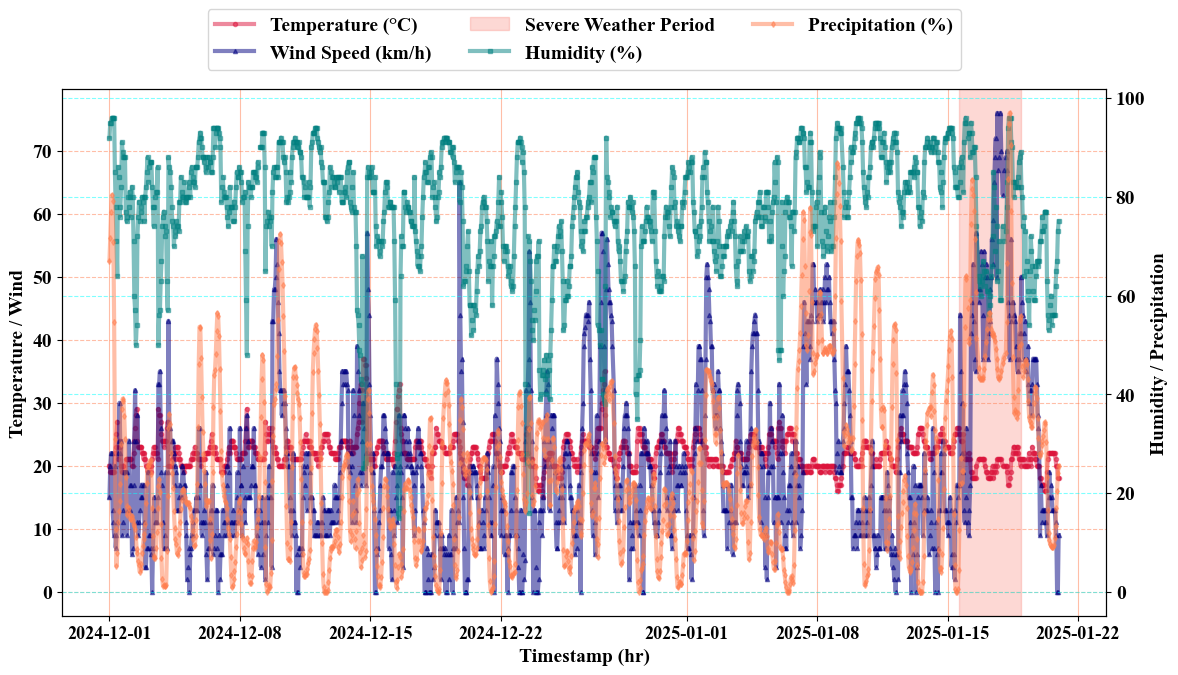

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set font globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "bold"

# Load the processed dataset with parsed timestamps
file_path = "Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"
df = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot temperature, wind speed
ax1.plot(
    df['Timestamp'],
    df['Temperature_C'],
    label='Temperature (°C)',
    color='crimson',
    linewidth=3,
    marker='o',
    markersize=3,
    alpha=0.5
)
ax1.plot(
    df['Timestamp'],
    df['Wind_km_h'],
    label='Wind Speed (km/h)',
    color='navy',
    linewidth=3,
    marker='^',
    markersize=3,
    alpha=0.5
)

# Plot humidity and precipitation on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(
    df['Timestamp'],
    df['Humidity_%'],
    label='Humidity (%)',
    color='teal',
    linewidth=3,
    marker='s',
    markersize=3,
    alpha=0.5
)
ax2.plot(
    df['Timestamp'],
    df['Precipitation_%'],
    label='Precipitation (%)',
    color='coral',
    linewidth=3,
    marker='d',
    markersize=3,
    alpha=0.5
)

# Axis labels
ax1.set_xlabel('Timestamp (hr)', fontweight='bold')
ax1.set_ylabel('Temperature / Wind', fontweight='bold')
ax2.set_ylabel('Humidity / Precipitation', fontweight='bold')

# # 1. Major ticks at 12:00 each day (so "10 Jan 2025" appears at midday)
# ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=12+1))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# # 2. Minor ticks = every 6 hours
# ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# 3. Vertical grid lines at every 6h (minor ticks)
ax1.grid(which='minor', linestyle='--', color='coral', alpha=0.5)

# 3a. Horizontal grid lines at each y‐major tick
ax1.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)

ax2.grid(which='major', axis='y', linestyle='--', color='cyan', alpha=0.5)

# 4. Ensure no grid at x‐major ticks
ax1.grid(which='major', axis='x', color='coral', alpha=0.5, visible=True)

# 5. Fix x‐axis range: Jan 10 00:00 → Jan 20 23:00
# start = pd.Timestamp("2025-01-10 00:00")
# end   = pd.Timestamp("2025-01-20 23:00")
# ax1.set_xlim(start, end)

# 6. Keep x‐axis labels horizontal & set font size
ax1.tick_params(axis='x', rotation=0, labelsize=13)

# Remove or comment out this line so labels stay horizontal:
# fig.autofmt_xdate()

# Shade 15–19 Jan as severe weather
ax1.axvspan(
    pd.Timestamp("2025-01-15 14:20"),
    pd.Timestamp("2025-01-18 22:59"),
    color='salmon',
    alpha=0.3,
    label='Severe Weather Period'
)

# Merge legends from both axes + shaded patch
lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines + lines2,
    labels + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=True
)

plt.tight_layout()
# plt.savefig(
#     "Figures/Wollongong_Weather_10_20_Jan_2025.png",
#     dpi=600,
#     bbox_inches='tight'
# )
plt.show()


In [5]:
df

,Timestamp,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%
0,2024-12-01 00:00:00,20.0,15.0,92.0,67.09
1,2024-12-01 01:00:00,19.0,20.0,95.0,71.61
2,2024-12-01 02:00:00,19.0,22.0,95.0,77.00
3,2024-12-01 03:00:00,19.0,22.0,96.0,80.34
4,2024-12-01 04:00:00,19.0,13.0,96.0,79.11
...,...,...,...,...,...
1205,2025-01-20 19:00:00,21.0,11.0,62.0,13.33
1206,2025-01-20 20:00:00,20.0,9.0,65.0,16.89
1207,2025-01-20 21:00:00,20.0,0.0,67.0,20.44
1208,2025-01-20 22:00:00,18.0,0.0,73.0,24.00


In [6]:
# import pandas as pd
# import numpy as np

# def estimate_irradiance_kwh(timestamp: pd.Timestamp, humidity_pct: float, latitude: float) -> float:
#     """
#     Approximate hourly surface irradiance (kWh/m²) by:
#       1) computing extraterrestrial normal irradiance (G_on),
#       2) projecting it to horizontal (G0h = G_on * sin(solar_elevation)),
#       3) applying a simple clearness index based on humidity (Kt = 1 − humidity_pct/100),
#       4) converting W/m² → kWh/m² for one hour.

#     Returns 0.0000 if the sun is below the horizon.
#     """
#     n = timestamp.timetuple().tm_yday
#     hour_decimal = timestamp.hour + timestamp.minute / 60.0
#     omega = (np.pi / 12.0) * (hour_decimal - 12.0)
#     delta = 0.409 * np.sin((2 * np.pi / 365) * n - 1.39)
#     phi = np.radians(latitude)

#     beta = np.arcsin(
#         np.sin(phi) * np.sin(delta) +
#         np.cos(phi) * np.cos(delta) * np.cos(omega)
#     )
#     if beta <= 0.0:
#         return 0.0

#     E0 = 1.0 + 0.033 * np.cos((2 * np.pi / 365) * n)
#     G_sc = 1367.0  # W/m²
#     G_on = G_sc * E0
#     G0h = G_on * np.sin(beta)  # W/m²

#     Kt = max(0.0, min(1.0 - (humidity_pct / 100.0), 1.0))
#     Gh = Kt * G0h
#     return round(Gh / 1000.0, 4)  # kWh/m²

In [7]:
# # Create a copy of the input DataFrame
# df_x = df.copy()
# # Convert the 'Timestamp' column to a datetime data type
# df_x['Timestamp'] = pd.to_datetime(df_x['Timestamp'])

In [8]:
# --------------------------- Script Starts Here ---------------------------
import pandas as pd
import numpy as np
import pytz

# === Your irradiance estimator (unchanged) ===============================
def estimate_irradiance_kwh(timestamp: pd.Timestamp, humidity_pct: float, latitude: float) -> float:
    """
    Approximate hourly surface irradiance (kWh/m²). Returns 0.0000 if the sun
    is below the horizon. For one-hour bins, kWh/m² == average kW/m².
    """
    n = timestamp.timetuple().tm_yday
    hour_decimal = timestamp.hour + timestamp.minute / 60.0
    omega = (np.pi / 12.0) * (hour_decimal - 12.0)  # hour angle
    delta = 0.409 * np.sin((2 * np.pi / 365) * n - 1.39)  # declination
    phi = np.radians(latitude)

    # Solar elevation
    beta = np.arcsin(
        np.sin(phi) * np.sin(delta) +
        np.cos(phi) * np.cos(delta) * np.cos(omega)
    )
    if beta <= 0.0:
        return 0.0

    # Extraterrestrial irradiance with Earth–Sun distance correction
    E0 = 1.0 + 0.033 * np.cos((2 * np.pi / 365) * n)
    G_sc = 1367.0  # W/m²
    G_on = G_sc * E0
    G0h = G_on * np.sin(beta)  # W/m² horizontal

    # Humidity-based clearness proxy
    Kt = max(0.0, min(1.0 - (humidity_pct / 100.0), 1.0))
    Gh = Kt * G0h
    return round(Gh / 1000.0, 4)  # kWh/m² (== kW/m² averaged over one hour)

# === Step 0: Load processed weather CSV with 'Humidity_%' column =========
input_path = "Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"
df = pd.read_csv(input_path, parse_dates=["Timestamp"])

# Ensure timezone-aware timestamps in Australia/Sydney
SYD = pytz.timezone("Australia/Sydney")
if df["Timestamp"].dt.tz is None:
    # Treat the timestamps as local Sydney time
    df["Timestamp"] = df["Timestamp"].dt.tz_localize(SYD)
else:
    # Convert to Sydney time if already tz-aware
    df["Timestamp"] = df["Timestamp"].dt.tz_convert(SYD)

# === Step 1: Compute clear-sky irradiance ================================
latitude = -34.416  # Wollongong latitude

# Safety: if any humidity is missing, assume 70% (conservative)
humidity_series = df["Humidity_%"].fillna(70.0)

df["Irradiance_kW/m2"] = [
    estimate_irradiance_kwh(ts.to_pydatetime(), hum, latitude)
    for ts, hum in zip(df["Timestamp"], humidity_series)
]

# === Step 2: Define severe-weather windows ===============================
# (A) Fill in December 2024 severe windows for Wollongong here if you have them.
# Example placeholders — leave empty [] if unknown for now:
# DEC_WINDOWS = [
#     (pd.Timestamp("2024-12-07 00:00", tz=SYD), pd.Timestamp("2024-12-08 23:59", tz=SYD)),
#     (pd.Timestamp("2024-12-19 12:00", tz=SYD), pd.Timestamp("2024-12-20 23:59", tz=SYD)),
# ]

# DEC_WINDOWS = [
#     (pd.Timestamp("2024-12-01 14:00", tz=SYD), pd.Timestamp("2024-12-01 20:00", tz=SYD)),  # Severe thunderstorm with heavy rain and flash flooding risk
#     (pd.Timestamp("2024-12-06 15:00", tz=SYD), pd.Timestamp("2024-12-06 21:00", tz=SYD)),  # Thunderstorm activity with damaging winds
#     (pd.Timestamp("2024-12-17 13:00", tz=SYD), pd.Timestamp("2024-12-17 19:00", tz=SYD)),  # Severe storms with hail and heavy rain
#     (pd.Timestamp("2024-12-27 14:00", tz=SYD), pd.Timestamp("2024-12-27 20:00", tz=SYD)),  # Late-month storms with heavy rainfall
# ]

DEC_WINDOWS = [
    (pd.Timestamp("2024-12-01 12:00", tz=SYD), pd.Timestamp("2024-12-01 23:59", tz=SYD)),  # Severe thunderstorm with heavy rain and flash flooding risk
    (pd.Timestamp("2024-12-06 12:00", tz=SYD), pd.Timestamp("2024-12-07 00:00", tz=SYD)),  # Thunderstorm activity with damaging winds
    (pd.Timestamp("2024-12-17 10:00", tz=SYD), pd.Timestamp("2024-12-17 22:00", tz=SYD)),  # Severe storms with hail and heavy rain
    (pd.Timestamp("2024-12-27 12:00", tz=SYD), pd.Timestamp("2024-12-27 23:59", tz=SYD)),  # Late-month storms with heavy rainfall
]

# (B) Your JAN-2025 ground-truth severe windows (given)
JAN_WINDOWS = [
    (pd.Timestamp("2025-01-07 14:20", tz=SYD), pd.Timestamp("2025-01-10 22:00", tz=SYD)),
    (pd.Timestamp("2025-01-15 04:30", tz=SYD), pd.Timestamp("2025-01-18 22:59", tz=SYD)),
]


SEVERE_WINDOWS = sorted(DEC_WINDOWS + JAN_WINDOWS, key=lambda w: w[0])

# === Step 3: Choose reduction factors ====================================
# Note: factors < 1.0 reduce irradiance.
FACTOR_PRE    = 1.10  # <- as you wrote; this slightly *increases* pre-storm irradiance
FACTOR_SEVERE = 0.15  # strong reduction during the storm
FACTOR_POST   = 0.40  # lingering reduction after the storm

# If you intended "80% of clear-sky before the storm" etc., set:
# FACTOR_PRE = 0.80; FACTOR_SEVERE = 0.10; FACTOR_POST = 0.90

# How far after each window should "post" conditions persist?
POST_TAIL_HOURS = 48  # adjust to taste

# === Step 4: Build a piecewise adjustment over multiple windows ==========
# Start with PRE everywhere
adj = np.full(len(df), FACTOR_PRE, dtype=float)

# Apply window-by-window:
ts = df["Timestamp"].values

for (start, end) in SEVERE_WINDOWS:
    # During severe window
    severe_mask = (ts >= np.datetime64(start)) & (ts <= np.datetime64(end))
    adj[severe_mask] = np.minimum(adj[severe_mask], FACTOR_SEVERE)

    # Post window tail (end, end + POST_TAIL_HOURS]
    post_end = end + pd.Timedelta(hours=POST_TAIL_HOURS)
    post_mask = (ts > np.datetime64(end)) & (ts <= np.datetime64(post_end))
    adj[post_mask] = np.minimum(adj[post_mask], FACTOR_POST)

# Apply the adjustment
df["Irradiance_kW/m2"] = (df["Irradiance_kW/m2"].values * adj * 1000).round(4)

# ---------------------------- Script Ends Here ----------------------------


C:\Users\rbmxu\AppData\Local\Temp\ipykernel_28280\2844864033.py:113: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  severe_mask = (ts >= np.datetime64(start)) & (ts <= np.datetime64(end))
C:\Users\rbmxu\AppData\Local\Temp\ipykernel_28280\2844864033.py:118: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  post_mask = (ts > np.datetime64(end)) & (ts <= np.datetime64(post_end))


In [9]:
df.describe()

,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%,Irradiance_kW/m2
count,1209.000000,1209.000000,1209.000000,1210.000000,1210.000000
mean,22.011580,20.103391,76.727874,24.442504,112.702017
std,2.539072,13.720123,12.744869,18.265622,183.513429
min,15.000000,0.000000,15.000000,0.000000,0.000000
25%,20.000000,11.000000,71.000000,10.247500,0.000000
50%,22.000000,17.000000,79.000000,20.000000,18.090000
75%,23.000000,26.000000,86.000000,35.220000,163.977500
max,37.000000,76.000000,96.000000,97.000000,1280.400000


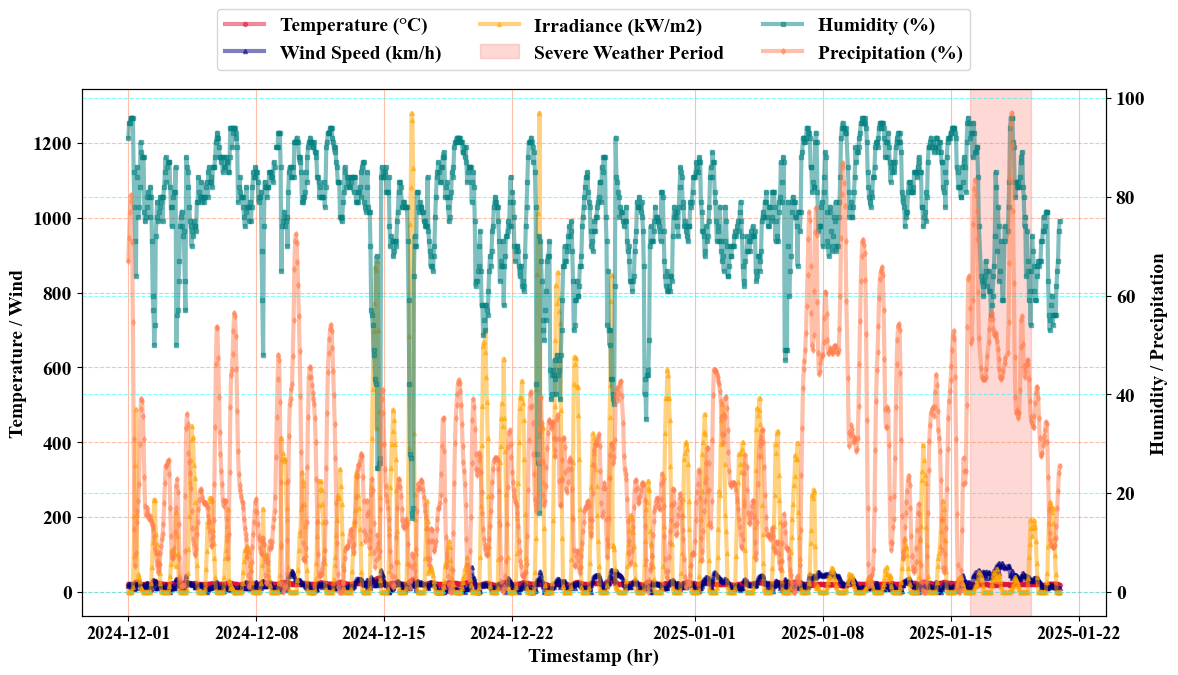

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set font globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "bold"

# # Load the processed dataset with parsed timestamps
# file_path = "Data/Exp/ProcessedData_Meteorological_Wollongong_01Dec24_to_20Jan25.csv"
# df = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot temperature, wind speed
ax1.plot(
    df['Timestamp'],
    df['Temperature_C'],
    label='Temperature (°C)',
    color='crimson',
    linewidth=3,
    marker='o',
    markersize=3,
    alpha=0.5
)
ax1.plot(
    df['Timestamp'],
    df['Wind_km_h'],
    label='Wind Speed (km/h)',
    color='navy',
    linewidth=3,
    marker='^',
    markersize=3,
    alpha=0.5
)
ax1.plot(
    df['Timestamp'],
    df['Irradiance_kW/m2'],
    label='Irradiance (kW/m2)',
    color='orange',
    linewidth=3,
    marker='^',
    markersize=3,
    alpha=0.5
)

# Plot humidity and precipitation on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(
    df['Timestamp'],
    df['Humidity_%'],
    label='Humidity (%)',
    color='teal',
    linewidth=3,
    marker='s',
    markersize=3,
    alpha=0.5
)
ax2.plot(
    df['Timestamp'],
    df['Precipitation_%'],
    label='Precipitation (%)',
    color='coral',
    linewidth=3,
    marker='d',
    markersize=3,
    alpha=0.5
)

# Axis labels
ax1.set_xlabel('Timestamp (hr)', fontweight='bold')
ax1.set_ylabel('Temperature / Wind', fontweight='bold')
ax2.set_ylabel('Humidity / Precipitation', fontweight='bold')

# # 1. Major ticks at 12:00 each day (so "10 Jan 2025" appears at midday)
# ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=12+1))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# # 2. Minor ticks = every 6 hours
# ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# 3. Vertical grid lines at every 6h (minor ticks)
ax1.grid(which='minor', linestyle='--', color='coral', alpha=0.5)

# 3a. Horizontal grid lines at each y‐major tick
ax1.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)

ax2.grid(which='major', axis='y', linestyle='--', color='cyan', alpha=0.5)

# 4. Ensure no grid at x‐major ticks
ax1.grid(which='major', axis='x', color='coral', alpha=0.5, visible=True)

# 5. Fix x‐axis range: Jan 10 00:00 → Jan 20 23:00
# start = pd.Timestamp("2025-01-10 00:00")
# end   = pd.Timestamp("2025-01-20 23:00")
# ax1.set_xlim(start, end)

# 6. Keep x‐axis labels horizontal & set font size
ax1.tick_params(axis='x', rotation=0, labelsize=13)

# Remove or comment out this line so labels stay horizontal:
# fig.autofmt_xdate()

# Shade 15–19 Jan as severe weather
ax1.axvspan(
    pd.Timestamp("2025-01-15 14:20"),
    pd.Timestamp("2025-01-18 22:59"),
    color='salmon',
    alpha=0.3,
    label='Severe Weather Period'
)

# Merge legends from both axes + shaded patch
lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines + lines2,
    labels + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=True
)

plt.tight_layout()
# plt.savefig(
#     "Figures/Wollongong_Weather_10_20_Jan_2025.png",
#     dpi=600,
#     bbox_inches='tight'
# )
plt.show()
